<a href="https://colab.research.google.com/github/manjitullal/Lung-Diseases-Detection/blob/main/Multi_Label_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

# download data from kaggle 

! mkdir ~/.kaggle
! cp /content/drive/MyDrive/datasets/kaggle/kaggle.json ~/.kaggle/

Mounted at /content/drive


In [ ]:
# download data from kaggle 

! kaggle datasets download -d nih-chest-xrays/data

# unzip the data 

! unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_012/images/00028897_016.png  
  inflating: images_012/images/00028897_017.png  
  inflating: images_012/images/00028897_018.png  
  inflating: images_012/images/00028897_019.png  
  inflating: images_012/images/00028897_020.png  
  inflating: images_012/images/00028898_000.png  
  inflating: images_012/images/00028899_000.png  
  inflating: images_012/images/00028899_001.png  
  inflating: images_012/images/00028899_002.png  
  inflating: images_012/images/00028900_000.png  
  inflating: images_012/images/00028901_000.png  
  inflating: images_012/images/00028901_001.png  
  inflating: images_012/images/00028902_000.png  
  inflating: images_012/images/00028902_001.png  
  inflating: images_012/images/00028902_002.png  
  inflating: images_012/images/00028902_003.png  
  inflating: images_012/images/00028902_004.png  
  inflating: images_012/images/00028902_005.png  
  inflating: images_012/images/00028902_006.png  

In [ ]:
!pip install randaugment

# Resent101
## 15 labels
### Using asymmetric loss

https://github.com/Alibaba-MIIL/ASL

https://arxiv.org/pdf/2009.14119.pdf

In [ ]:
import os
import argparse
import torch
import torch.nn.parallel
import torch.optim
import torch.nn as nn
import torch.utils.data.distributed
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.optim import lr_scheduler
from randaugment import RandAugment
from torch.cuda.amp import GradScaler, autocast

import pandas as pd
import numpy as np
import os
from os import path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from scipy import interp
from itertools import cycle
from glob import glob
from itertools import chain
import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
labels_path = '/content/Data_Entry_2017.csv'
train_path = '/content/train_val_list.txt' 
test_path = '/content/test_list.txt'

all_xray_df = pd.read_csv(labels_path)
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/content/', 'images*', '*', '*.png'))}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/content/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/content/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/content/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/content/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/content/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [ ]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [ ]:
train_df, test_df = train_test_split(all_xray_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))

train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 2018,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))


train_df = train_df.reset_index(drop = True)
valid_df = valid_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0])

train 90817 validation 10091 test 11212


In [ ]:
transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
])

transform_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485],
        std=[0.229])
        ])

In [ ]:
class NoneTransform(object):    
    def __call__(self, image):       
        return image

class NIHDataset:
    def __init__(
        self,
        image_paths,
        labels,
        resize,
        torch_augs=None,
        augmentations=None,
        backend="cv2",
        channel_first= True,
    ):        
        self.image_paths = image_paths        
        self.labels = labels
        self.resize = resize        
        self.torch_augs = torch_augs
        self.augmentations = augmentations
        self.backend = backend
        self.channel_first = channel_first

    def __len__(self):
        return len(self.image_paths)    

    def __getitem__(self, item):
        targets = self.labels[item]

        if self.backend == "pil":
            image = Image.open(self.image_paths[item]).convert("RGB")  
  
            if self.resize is not None:
                image = image.resize(
                    (self.resize[1], self.resize[0]), resample=Image.BILINEAR
                )
            if self.augmentations is not None:
                image = np.array(image)
                augmented = self.augmentations(image=image)
                image = augmented["image"]
                
            if self.torch_augs is not None:
                image = self.torch_augs(image)                
        
        else:
            raise Exception("Backend not implemented")
        
        if self.channel_first:
            image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return image, torch.tensor(np.array(targets, dtype='float'))

In [ ]:
trainset = NIHDataset(train_df['path'], 
                      train_df['disease_vec'],  
                      resize= None,
                      torch_augs=transform_train,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

validset = NIHDataset(valid_df['path'], 
                      valid_df['disease_vec'],  
                      resize= None, 
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

testset = NIHDataset(test_df['path'], 
                      test_df['disease_vec'],  
                      resize= None, 
                      torch_augs=transform_val,
                      augmentations=None,
                      backend="pil", 
                      channel_first=False)

bs = 16

trainloader = DataLoader(trainset, batch_size=bs, shuffle=True)
valloader = DataLoader(validset, batch_size=bs, shuffle=True)
testloader = DataLoader(testset, batch_size=bs, shuffle=True)

In [ ]:
print (len(trainloader), len(valloader), len(testloader))

5677 631 701


In [ ]:
!pip install timm

     |████████████████████████████████| 296kB 13.0MB/s 


In [ ]:
import timm
class ResNet101(nn.Module):
    def __init__(self, model_name='resnet101', out_dim=15, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, out_dim)

    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return output

In [ ]:
model_r = ResNet101()
model_r.to(device)

#https://www.kaggle.com/underwearfitting/resnet200d-public-benchmark-2xtta-lb0-965

ResNet101(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
import os
from copy import deepcopy
import random
import time
from copy import deepcopy

class ModelEma(torch.nn.Module):
    def __init__(self, model, decay=0.9997, device=None):
        super(ModelEma, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)

In [ ]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


In [ ]:
def add_weight_decay(model, weight_decay=1e-4, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [ ]:
def average_precision(output, target):
    epsilon = 1e-8

    # sort examples
    #indices = output.argsort()[::-1]
    # Computes prec@i
    total_count_ = np.cumsum(np.ones((len(output), 1)))

    #target_ = target[indices]
    target_ = target

    ind = target_ == 1
    pos_count_ = np.cumsum(ind)
    total = pos_count_[-1]
    pos_count_[np.logical_not(ind)] = 0
    pp = pos_count_ / total_count_
    precision_at_i_ = np.sum(pp)
    precision_at_i = precision_at_i_ / (total + epsilon)

    return precision_at_i

In [ ]:
def mAP(targs, preds):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        # sort scores
        scores = preds[:, k]
        targets = targs[:, k]
        # compute average precision
        ap[k] = average_precision(scores, targets)
    return 100 * ap.mean()

In [ ]:
def train_multi_label_nih(model, train_loader, val_loader, lr):
    ema = ModelEma(model, 0.9997)  # 0.9997^641=0.82

    # set optimizer
    Epochs = 10
    Stop_epoch = 40
    weight_decay = 1e-4
    criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=False)
    parameters = add_weight_decay(model, weight_decay)
    optimizer = torch.optim.Adam(params=parameters, lr=lr, weight_decay=0)  # true wd, filter_bias_and_bn
    steps_per_epoch = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=Epochs,
                                        pct_start=0.2)

    highest_mAP = 0
    trainInfoList = []
    scaler = GradScaler()
    for epoch in range(Epochs):
        if epoch > Stop_epoch:
            break
        for i, (inputData, target) in enumerate(train_loader):
            inputData = inputData.cuda()
            target = target.cuda()  # (batch,3,num_classes)
            #target = target.max(dim=1)[0]
            #import pdb; pdb.set_trace();
            with autocast():  # mixed precision
                output = model(inputData).float()  # sigmoid will be done in loss !
            loss = criterion(output, target)
            model.zero_grad()

            scaler.scale(loss).backward()
            # loss.backward()

            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            scheduler.step()

            ema.update(model)
            # store information
            if i % 100 == 0:
                trainInfoList.append([epoch, i, loss.item()])
                print('Epoch [{}/{}], Step [{}/{}], LR {:.1e}, Loss: {:.1f}'
                      .format(epoch, Epochs, str(i).zfill(3), str(steps_per_epoch).zfill(3),
                              scheduler.get_last_lr()[0], \
                              loss.item()))

        try:
            torch.save(model.state_dict(), os.path.join(
                'models/', 'model-{}-{}.ckpt'.format(epoch + 1, i + 1)))
        except:
            pass

        model.eval()
        mAP_score = validate_multi(val_loader, model, ema)
        model.train()
        if mAP_score > highest_mAP:
            highest_mAP = mAP_score
            try:
                torch.save(model.state_dict(), os.path.join(
                    'models/', 'model-highest.ckpt'))
            except:
                pass
        print('current_mAP = {:.2f}, highest_mAP = {:.2f}\n'.format(mAP_score, highest_mAP))


def validate_multi(val_loader, model, ema_model):
    print("starting validation")
    Sig = torch.nn.Sigmoid()
    preds_regular = []
    preds_ema = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target
        #target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            with autocast():
                output_regular = Sig(model(input.cuda())).cpu()
                output_ema = Sig(ema_model.module(input.cuda())).cpu()

        # for mAP calculation
        preds_regular.append(output_regular.cpu().detach())
        preds_ema.append(output_ema.cpu().detach())
        targets.append(target.cpu().detach())

    mAP_score_regular = mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
    mAP_score_ema = mAP(torch.cat(targets).numpy(), torch.cat(preds_ema).numpy())
    print("mAP score regular {:.2f}, mAP score EMA {:.2f}".format(mAP_score_regular, mAP_score_ema))
    return max(mAP_score_regular, mAP_score_ema)

In [ ]:
# Setup model
print('creating model...')
model = model_r

#
path = '/content/drive/MyDrive/Projects/DS5500/final/'

# Actuall Training
train_multi_label_nih(model, trainloader, valloader, 1e-4)

creating model...
Epoch [0/10], Step [000/5677], LR 4.0e-06, Loss: 21.0
Epoch [0/10], Step [100/5677], LR 4.0e-06, Loss: 17.4
Epoch [0/10], Step [200/5677], LR 4.1e-06, Loss: 12.1
Epoch [0/10], Step [300/5677], LR 4.2e-06, Loss: 15.7
Epoch [0/10], Step [400/5677], LR 4.3e-06, Loss: 13.8
Epoch [0/10], Step [500/5677], LR 4.5e-06, Loss: 10.3
Epoch [0/10], Step [600/5677], LR 4.7e-06, Loss: 17.9
Epoch [0/10], Step [700/5677], LR 4.9e-06, Loss: 12.1
Epoch [0/10], Step [800/5677], LR 5.2e-06, Loss: 19.4
Epoch [0/10], Step [900/5677], LR 5.5e-06, Loss: 11.9
Epoch [0/10], Step [1000/5677], LR 5.8e-06, Loss: 15.6
Epoch [0/10], Step [1100/5677], LR 6.2e-06, Loss: 14.2
Epoch [0/10], Step [1200/5677], LR 6.6e-06, Loss: 12.3
Epoch [0/10], Step [1300/5677], LR 7.1e-06, Loss: 13.5
Epoch [0/10], Step [1400/5677], LR 7.6e-06, Loss: 13.7
Epoch [0/10], Step [1500/5677], LR 8.1e-06, Loss: 17.3
Epoch [0/10], Step [1600/5677], LR 8.6e-06, Loss: 11.4
Epoch [0/10], Step [1700/5677], LR 9.2e-06, Loss: 14.3
Ep

In [31]:
# v1 was 5 epochs 
# v2 was 10 epochs

torch.save(model.state_dict(), path + 'Resnet-101-ASL_NIH_v2.pt')

In [32]:
path = '/content/drive/MyDrive/Projects/DS5500/final/'

model_r = ResNet101()
model_r.load_state_dict(torch.load(path + 'Resnet-101-ASL_NIH_v2.pt'))
model_r.eval()
model_r.to(device)

criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=False)

In [33]:
def test(model, testloader):
  model.eval()
  with torch.no_grad():
    losses = list()
    accuracy = list()    
    test_statistics = {'loss':[],'accuracy':[], 'probability':[], 'logits':[], 'label':[]}
    for batch in testloader:
      image, label = batch
      image, label = image.to(device), label.to(device)

      output = model(image)
      loss = criterion(output, label)
      
      output_logits = (torch.sigmoid(output)>0.5).float()
      correct = torch.sum(torch.sum(output_logits == label , 1) == 14) # 14 because there are 14 labels 

      losses.append(loss.item())
      accuracy.append(correct/14)

      test_statistics['loss'].append(loss.item())
      test_statistics['accuracy'].append(correct/14)
      test_statistics['probability'].append(torch.sigmoid(output.cpu()))      
      test_statistics['logits'].append(output_logits.cpu())            
      test_statistics['label'].append(label.cpu()) 

  print(f'Average test loss: {torch.tensor(losses).mean()}')
  print(f'Average test accuracy: {torch.tensor(accuracy).mean()}')
  return test_statistics

In [34]:
%%time

test_statistics = test(model_r, testloader)

Average test loss: 13.802260398864746
Average test accuracy: 0.1807621866464615
CPU times: user 6min 47s, sys: 10.7 s, total: 6min 58s
Wall time: 4min 4s


In [35]:
y_pred = test_statistics['probability']
y_pred = torch.cat(y_pred, axis=0)

y_truelabel = test_statistics['label']
y_truelabel = torch.cat(y_truelabel, axis=0)

y_predlabel = test_statistics['logits']
y_predlabel = torch.cat(y_predlabel, axis=0)

In [36]:
n_classes = 15

def plot_roc(y_test, y_score, title):

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(13,10))
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'yellow', 'gray', 'lime', 'black', 'gold', 'cyan', 'violet', 'teal'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(all_labels[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

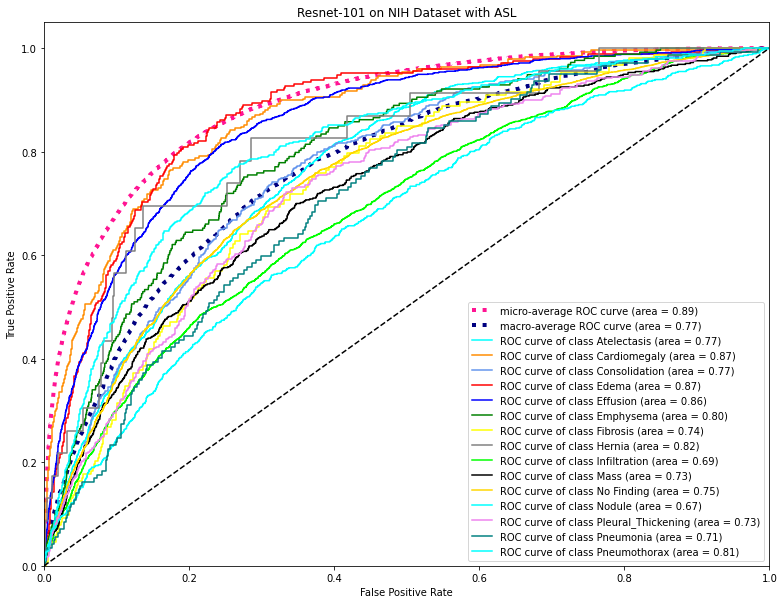

In [ ]:
# plot_roc(y_truelabel, y_pred, 'Resnet-101 on NIH Dataset with ASL')

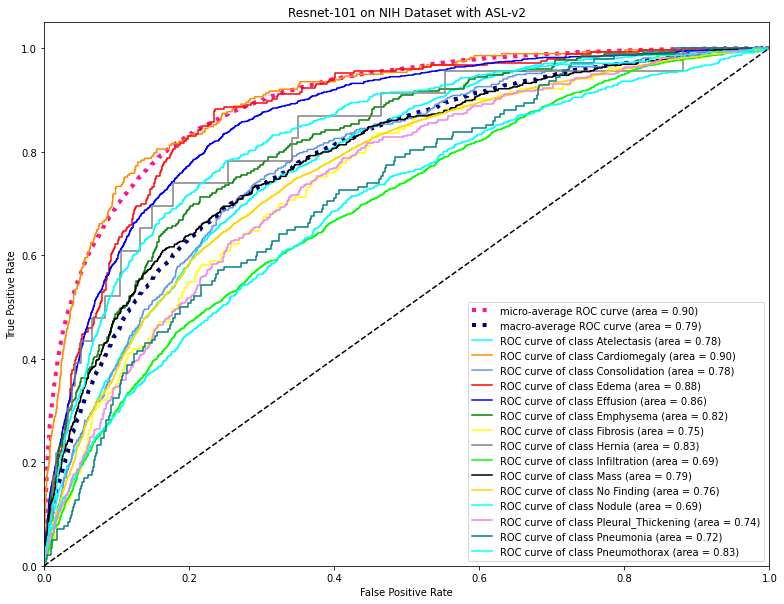

In [37]:
plot_roc(y_truelabel, y_pred, 'Resnet-101 on NIH Dataset with ASL-v2')